# Simulating optical auto correlation of a pulsed laser (with chirp)

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import constants
from scipy import integrate
from scipy import fftpack
from scipy import signal
from scipy import interpolate
from scipy import optimize
from scipy import constants
import pickle
from pathlib import Path

from chirp_diagnostic_functions import *

from IPython.core.debugger import set_trace
from datetime import datetime

Define figure path:

In [2]:
FIGURE_PATH = Path("../../Masterthesis/figures/chirp/plots/direct-output/")

Change resolution of plots so that they don't appear super small:
https://stackoverflow.com/a/55289762/11038610

Globally change settings of matplotlib-Plots.

In [3]:
plt.rcParams.update({
    'font.size': 7,
    'figure.dpi': 200,
    'figure.figsize': (6.2, 2.2),
    'lines.linewidth': 0.5,    
})

Electric field of a laser $E(t)$ with a chirp is relative to the form:

$$E(t) \sim \mathrm{Re}(f^{1/2}(t) \cdot \exp\left(-i \omega t - i \phi(t)\right))$$

with the central frequency $\omega$ and the linear chirp $\phi(t)$:

- for an gaussian pulse $f_{gauss}(t)$ is:
$$f_{gauss}(t) = \left(\frac{A_{gauss}}{\sqrt{2 \cdot \pi \cdot \tau_0 \cdot \tau}} \exp\left(-\frac{t^2}{2 \cdot \tau^2}\right)\right)^2$$

 - with the normalization constant $A_{gauss}$, the pulse duration $\tau_0$, the central frequency $w$ and the chirp coefficient $\alpha$.

 - where $\tau = \sqrt{\alpha^2 / \tau_0^2 + \tau_0^2}$ characterizes the chirped pulse length and $a = \alpha / (\alpha ^ 2 + \tau _0 ^ 4)$ is the frequency chirp rate.
 
 - with the linear chirp:
$$\phi_{gauss}(t) = \frac{a_{gauss} t^2}{2}$$

- for an secant pulse $f_{secant}(t)$ is:
$$f_{secant}(t) = A_{secant} \cdot sech^2\left(\frac{t}{\tau_0}\right) = A_{secant} \cdot \left(\frac{2}{exp(\frac{t}{\tau_0}) + exp(-\frac{t}{\tau_0})}\right)^2$$

 - with the linear chirp:
$$\phi_{secant}(t) = a_{secant}\left(\frac{t}{\tau_0}\right)^2$$


see: 
- Glässl, M., Barth, A. M., Gawarecki, K., MacHnikowski, P., Croitoru, M. D., Lüker, S., … Axt, V. M. (2013). Biexciton state preparation in a quantum dot via adiabatic rapid passage: Comparison between two control protocols and impact of phonon-induced dephasing. Physical Review B - Condensed Matter and Materials Physics, 87(8), 1–8. http://doi.org/10.1103/PhysRevB.87.085303
- Hirayama, T., & Sheik-Bahae, M. (2002). Real-time chirp diagnostic for ultrashort laser pulses. Optics Letters, 27(10), 860. http://doi.org/10.1364/OL.27.000860).



MaiTai Laser | values
-----------|--------------
repitition rate| 80 MHz
center wavelength (tunable) $\lambda_0$| 700 nm to 1000 nm
power | 3.2 Watt
pulse duration $\tau_0$ | 100 fs - 20 ps

We start with the pulse duration $\tau_0$ in (ps) and choose the central wavelength $\lambda$ in (pm).

In [4]:
tau_0_laser = 0.5
lambda_laser = 785e3

frequency_laser = constants.c / lambda_laser
omega_laser = 2 * np.pi * frequency_laser

We calculate E for different $\alpha$ in (ps)$^2$ for gauss and unitless for secant.

In [5]:
alpha_gauss_values = np.array((0.1, 0.5))
alpha_secant_values = np.array((0.0, 1))

Calculate $A$-arrays so that $\int f(t) dt = 1$

In [6]:
A_gauss = normalize_f(f_gauss, tau_0_laser, omega_laser)
A_secant = normalize_f(f_secant, tau_0_laser, omega_laser)

Set t_limit

In [7]:
t_limit = 30 * tau_0_laser
t_values_1 = np.linspace(-t_limit, t_limit, 12000)

In [8]:
E_gauss_values_1 = np.empty((t_values_1.size, alpha_gauss_values.size), dtype=complex)
for i in range(alpha_gauss_values.size):
    E_gauss_values_1[:,i] = E_gauss(t_values_1, A_gauss, tau_0_laser,
                                    omega_laser, alpha_gauss_values[i])
    
E_secant_values_1 = np.empty((t_values_1.size, alpha_secant_values.size), dtype=complex)
for i in range(alpha_secant_values.size):
    E_secant_values_1[:,i] = E_secant(t_values_1, A_secant, tau_0_laser,
                                    omega_laser, alpha_secant_values[i])

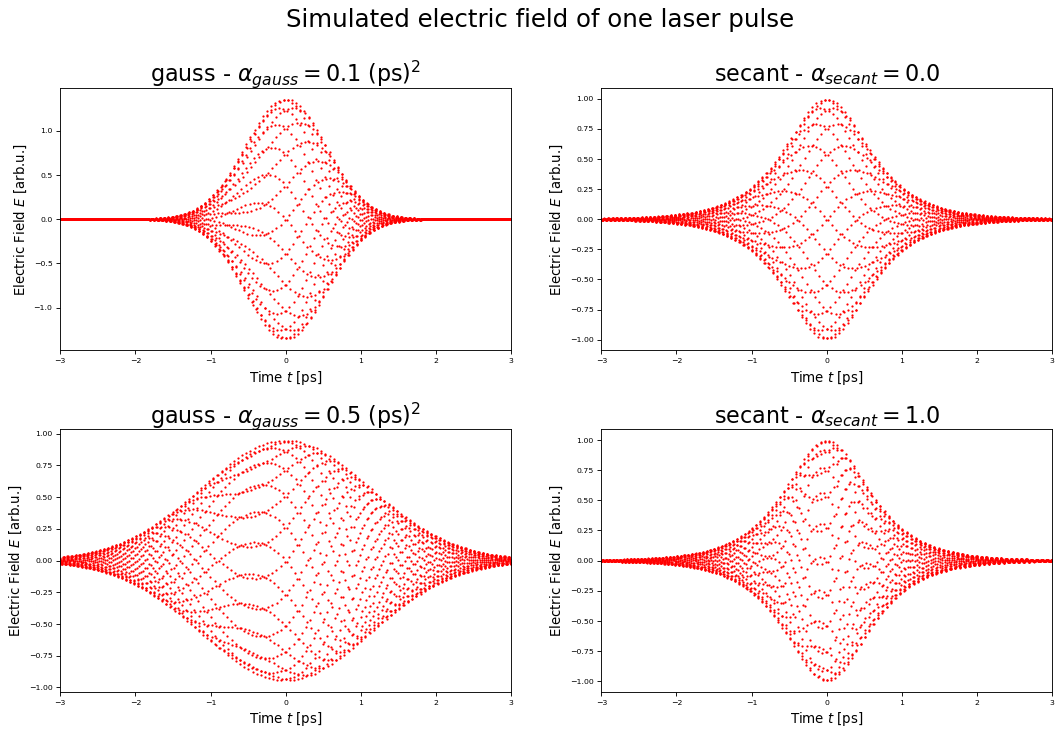

In [9]:
plt.figure(figsize=(16, max(alpha_gauss_values.size, alpha_secant_values.size) * 5), dpi=80)
plt.subplots_adjust(hspace = 0.3)
plt.suptitle('Simulated electric field of one laser pulse', fontsize = 22)

for i in range(alpha_gauss_values.size):
    plt.subplot(max(alpha_gauss_values.size, alpha_secant_values.size), 2, 2 * i + 1)
    plt.title(r"gauss - $\alpha_{gauss}" + " = {}$ (ps)$^2$".format(alpha_gauss_values[i]), fontsize=20)
    plt.xlabel(r"Time $t$ [ps]", fontsize = 12)
    plt.ylabel(r"Electric Field $E$ [arb.u.]", fontsize = 12)
    plt.xlim(- tau_0_laser * 6, tau_0_laser * 6)
    plt.plot(t_values_1, np.real(E_gauss_values_1[:,i]), "r.", markersize=2)

for i in range(alpha_secant_values.size):
    plt.subplot(max(alpha_gauss_values.size, alpha_secant_values.size), 2, 2 * i + 2)
    plt.title(r"secant - $\alpha_{secant}" + " = {}$".format(alpha_secant_values[i]), fontsize=20)
    plt.xlabel(r"Time $t$ [ps]", fontsize = 12)
    plt.ylabel(r"Electric Field $E$ [arb.u.]", fontsize = 12)
    plt.xlim(- tau_0_laser * 6, tau_0_laser * 6)
    plt.plot(t_values_1, np.real(E_secant_values_1[:,i]), "r.", markersize=2)

plt.show()

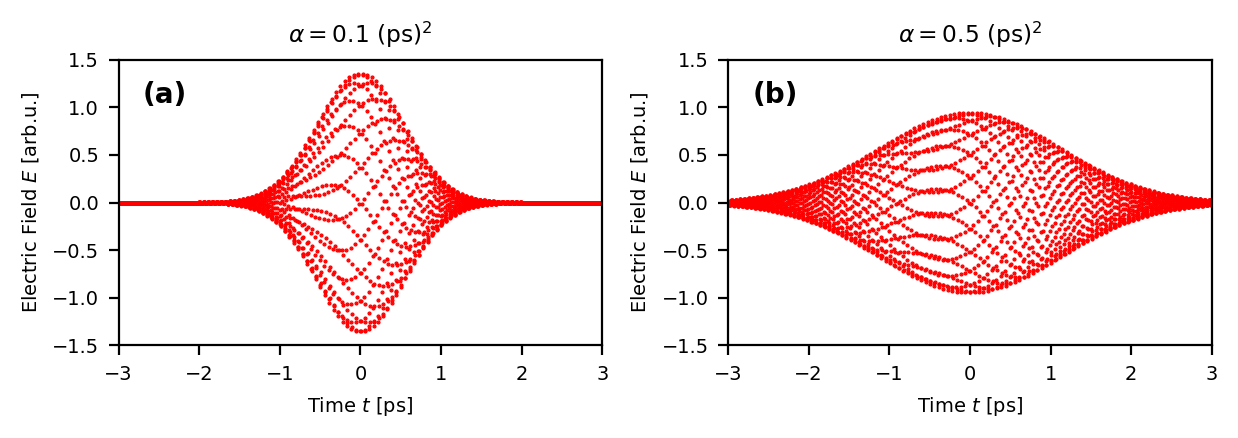

In [10]:
plt.subplot(1, 2, 1)
plt.title(r"$\alpha" + " = {:.1f}$ (ps)$^2$".format(alpha_gauss_values[0]))
plt.xlabel(r"Time $t$ [ps]")
plt.ylabel(r"Electric Field $E$ [arb.u.]")
plt.xlim(- tau_0_laser * 6, tau_0_laser * 6)
plt.ylim(-1.5, 1.5)
plt.plot(t_values_1, np.real(E_gauss_values_1[:,0]), "r.", markersize=1)
plt.text(0.05, 0.85, '(a)', fontsize=10, transform=plt.gca().transAxes, fontweight='bold')

plt.subplot(1, 2, 2)
plt.title(r"$\alpha" + " = {:.1f}$ (ps)$^2$".format(alpha_gauss_values[1]))
plt.xlabel(r"Time $t$ [ps]")
plt.ylabel(r"Electric Field $E$ [arb.u.]")
plt.xlim(- tau_0_laser * 6, tau_0_laser * 6)
plt.ylim(-1.5, 1.5)
plt.plot(t_values_1, np.real(E_gauss_values_1[:,1]), "r.", markersize=1)
plt.text(0.05, 0.85, '(b)', fontsize=10, transform=plt.gca().transAxes, fontweight='bold')

plt.tight_layout()
plt.savefig(FIGURE_PATH / "chirped_laser_pulse.pdf")
plt.show()

# Interferometric autocorrelation

![Setup for an interferometric autocorrelator](https://upload.wikimedia.org/wikipedia/en/d/dd/Optical-interferometric-autocorrelation-setup.png)

Setup for an interferometric autocorrelator, similar to the field autocorrelator above, with the following optics added:
- **L**: converging lens,
- **SHG**: second-harmonic generation crystal,
- **F**: spectral filter to block the fundamental wavelength.

see:
- https://en.wikipedia.org/wiki/Optical_autocorrelation
- Hirayama, T., & Sheik-Bahae, M. (2002). Real-time chirp diagnostic for ultrashort laser pulses. Optics Letters, 27(10), 860. http://doi.org/10.1364/OL.27.000860
- J.-C. Diels and W. Rudolph, Ultrashort Laser Pulse Phenomena: Fundamentals, Techniques and Applications on a Femtosecond Time Scale (Academic, San Diego, Calif., 1996).

The intensity recorded by the detecter is:

$$ I_M(\tau) = \int_{-\infty}^{+\infty}\langle|(E(t)+E(t-\tau))^2|^2\rangle dt $$

Here $\langle \rangle$ denotes averaging over fast oscillations of the electric field and the integral stands for integration over the pulse envelope. 

$$I_M(\tau) = 1 + 2 \int f(t) f(t + \tau) dt + \int f(t) f(t + \tau) cos(2 \omega \tau + 2 \Delta \phi) dt \\
+ 2 \int f^{1/2}(t) f^{3/2}(t + \tau) cos(\omega \tau + \Delta \phi) dt + 2 \int f^{3/2}(t) f^{2/2}(t + \tau) cos(\omega \tau + \Delta \phi) dt$$

where $\Delta \phi(t, \tau) = \phi(t + \tau) - \phi(t)$ and $\int f(t) dt = 1$ 

We obtain the filtered MOSAIC by modifiyng the interferometrac autocorrelation (IAC) spectrum as follows:
 - the $\omega$ terms are eliminated
 - the $2\omega$ term is amplified by the factor 2
 - the intensity autocorrelation term is unchanged


This spectral modification gives the time-domain MOSAIC signal:

$$I_{M, filtered}(\tau) = 1 + 2 \int f(t) f(t + \tau) dt + 2 \int f(t) f(t + \tau) cos(2\omega \tau + 2\Delta \phi) dt
                        = 1 + 2 \cdot \int f(t) f(t + \tau) \cdot (1 + cos(2\omega \tau + 2\Delta \phi)) dt $$


In [11]:
def I_M_filtered(f, delta_phi, tau_values, A, tau_0, omega, alpha):
    I_M_values = np.array(())
    for tau in tau_values:
        func = lambda t: f(t, A, tau_0, omega, alpha) * f(t + tau, A, tau_0, omega, alpha) * (1 + np.cos(2 * omega * tau - 2 * delta_phi(t, tau, tau_0, alpha)))
    # "[0]" because quad returns array, with "[0]" as the result and "[1]" as the error
        I_M_values = np.append(I_M_values,
                               1 + 2 * integrate.quad(func, - np.inf, np.inf)[0]) 
    return I_M_values

Number of $\tau$-values to calculate:

In [12]:
tau_limit = tau_0_laser * 6

Calculate the number of values so we can fft to at least $3 \cdot \omega$ 

$$3 \cdot \frac{\omega_{laser}}{2\pi} < f_{nyq} = \frac{f_{sampling}}{2} = \frac{\frac{\textit{number_tau_values}}{\textit{tau_limit} \cdot 2}}{2} $$

$$\Rightarrow \textit{number_tau_values} = \frac{6}{\pi} \cdot \textit{tau_limit} \cdot \omega_{laser} $$

"//100 * 100 + 100" so we don't get an integer multiple (which brings weird results)

In [13]:
number_tau_values = int((6 / np.pi * tau_limit * omega_laser)//100 * 100 + 100)

In [14]:
def gen_I_M_filtered_values(f, delta_phi, tau_limit, number_tau_values, alpha_values,  A, tau_0, omega):
    tau_values = np.linspace(-tau_limit, tau_limit, number_tau_values)
    I_M_values = np.empty((tau_values.size, alpha_values.size))    
    for i in range(alpha_values.size):
        I_M_values[:,i] = I_M_filtered(f, delta_phi, tau_values, A, tau_0, omega, alpha_values[i])
    return tau_values, I_M_values

In [15]:
path = r"../../Data/Autocorrelator/Simulation/"

In [16]:
while(True):
    answer_1 = input('Should we generate and save for gauss (g) or secant (s) pulse?: ')   
    if answer_1 == "g":        
        laser_shape = "gauss"
        alpha_values = alpha_gauss_values
        tau_values_1, I_M_filtered_values_1 = gen_I_M_filtered_values(f_gauss, delta_phi_gauss, tau_limit, number_tau_values,
                                                              alpha_gauss_values,  A_gauss,
                                                              tau_0_laser, omega_laser)        
        
        filename =  path + str(datetime.now()).replace(":", "_")     \
                   + "_Autocorrelation_Simulation_Gauss"             \
                   + ".pkl"
                
        with open(filename, 'wb') as file:
            pickle.dump(["simulation", laser_shape, tau_values_1, I_M_filtered_values_1,
                         tau_0_laser, omega_laser, alpha_gauss_values], file)

        break
    if answer_1 == "s":
        laser_shape = "secant"
        alpha_values = alpha_secant_values
        tau_values_1, I_M_filtered_values_1 = gen_I_M_filtered_values(f_secant, delta_phi_secant, tau_limit, number_tau_values,
                                                              alpha_secant_values,  A_secant,
                                                              tau_0_laser, omega_laser)
        
        filename =  path + str(datetime.now()).replace(":", "_")     \
                   + "_Autocorrelation_Simulation_Secant"            \
                   + ".pkl"
                
        with open(filename, 'wb') as file:
            pickle.dump(["simulation", laser_shape, tau_values_1, I_M_filtered_values_1,
                         tau_0_laser, omega_laser, alpha_secant_values], file)

        break

Should we generate and save for gauss (g) or secant (s) pulse?:  g


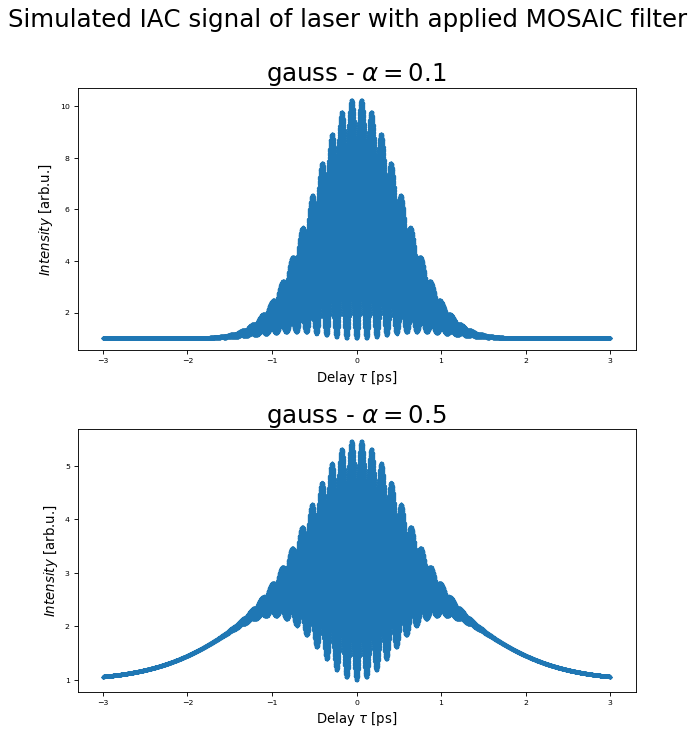

In [17]:
plt.figure(figsize=(9, alpha_values.size * 5), dpi=80)
plt.subplots_adjust(hspace = 0.3)
plt.suptitle('Simulated IAC signal of laser with applied MOSAIC filter', fontsize = 22)
for i in range(alpha_values.size):   
    
    plt.subplot(alpha_values.size, 1, i + 1)
    plt.title(laser_shape + r" - $\alpha = {}$".format(alpha_values[i]), fontsize=22)
    plt.xlabel(r"Delay $\tau$ [ps]", fontsize = 12)
    plt.ylabel(r"$Intensity$ [arb.u.]", fontsize = 12)
    plt.plot(tau_values_1, I_M_filtered_values_1[:,i], ".", ls="-", markersize=4)   

plt.show()